In [10]:
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras.layers import Dense, Flatten, Dropout
from tensorflow.keras.preprocessing.image import ImageDataGenerator, load_img
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping
from tensorflow.keras import Model, Sequential
from tensorflow.keras.models import load_model

In [42]:
train_path = 'data/cartoon/train/'
test_path = 'data/cartoon/test/'
val_path = 'data/cartoon/val/'

image_gen = ImageDataGenerator(rescale=1/255.,horizontal_flip=True, rotation_range=30, shear_range=0.15)


In [43]:
train_gen = image_gen.flow_from_directory(train_path,batch_size=32,
                                          target_size = (224,224),
                                          class_mode = 'sparse',
                                          seed =2020)

test_gen = image_gen.flow_from_directory(test_path,batch_size=32,
                                          target_size = (224,224),
                                          class_mode = 'sparse',
                                          seed =2020)

val_gen = image_gen.flow_from_directory(val_path,batch_size=32,
                                          target_size = (224,224),
                                          class_mode = 'sparse',
                                          seed =2020)

Found 794 images belonging to 2 classes.
Found 151 images belonging to 2 classes.
Found 339 images belonging to 2 classes.


C:\Users\user\AppData\Local\Temp\ipykernel_11928\126583187.py:10: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  plt.title(class_labels[labels[i].astype(np.int)])


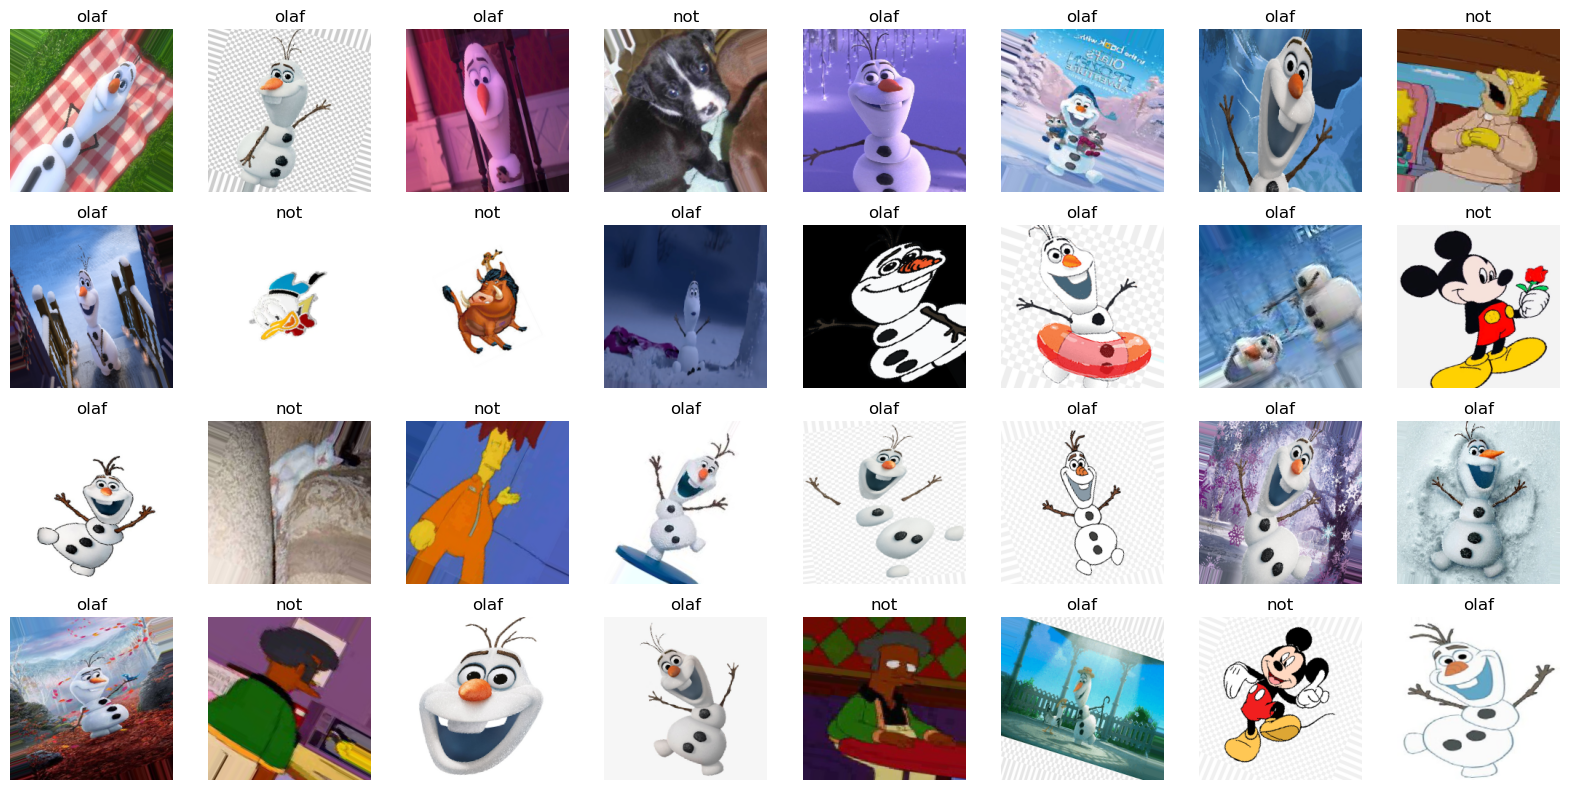

In [44]:
class_labels = ['not','olaf']
batch = next(train_gen)
images,labels = batch[0],batch[1]

plt.figure(figsize=(16,8))
for i in range(32):

    ax = plt.subplot(4,8,i+1)
    plt.imshow(images[i])
    plt.title(class_labels[labels[i].astype(np.int)])
    plt.axis('off')

plt.tight_layout()
plt.show()

In [45]:
from tensorflow.keras.applications import vgg19
vgg_model = vgg19.VGG19(weights='imagenet', include_top=False, input_shape=(224,224,3))
vgg_model.summary()

Model: "vgg19"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_5 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 224, 224, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 224, 224, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 112, 112, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 112, 112, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 112, 112, 128)     147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 56, 56, 128)       0     

In [46]:
for layer in vgg_model.layers:
    layer.trainable = False

In [47]:
model = Sequential()
model.add(vgg_model)
model.add(Flatten())
model.add(Dense(256, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(2, activation='softmax'))
model.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 vgg19 (Functional)          (None, 7, 7, 512)         20024384  
                                                                 
 flatten_4 (Flatten)         (None, 25088)             0         
                                                                 
 dense_6 (Dense)             (None, 256)               6422784   
                                                                 
 dropout (Dropout)           (None, 256)               0         
                                                                 
 dense_7 (Dense)             (None, 2)                 514       
                                                                 
Total params: 26,447,682
Trainable params: 6,423,298
Non-trainable params: 20,024,384
_________________________________________________________________


In [48]:
# 체크포인트 설정
checkpoint = ModelCheckpoint(filepath='checkpoint_weight.ckpt', save_weights_only=True, save_best_only=True, monitor='val_accuracy', verbose=1)

# 조기종료
earlystopping = EarlyStopping(monitor='val_accuracy', patience=3)

In [49]:
model.compile(optimizer="adam", loss="sparse_categorical_crossentropy", metrics=["accuracy"])

In [50]:
hist = model.fit(
    train_gen, 
    validation_data=val_gen, 
    epochs=20,
    callbacks=[checkpoint, earlystopping]
)

Epoch 1/20
 8/25 [========>.....................] - ETA: 1:16 - loss: 4.9939 - accuracy: 0.5391

c:\Users\user\anaconda3\lib\site-packages\PIL\Image.py:996: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


25/25 [==============================] - ETA: 0s - loss: 2.7162 - accuracy: 0.6222
Epoch 1: val_accuracy improved from -inf to 0.87611, saving model to checkpoint_weight.ckpt
25/25 [==============================] - 206s 8s/step - loss: 2.7162 - accuracy: 0.6222 - val_loss: 0.3044 - val_accuracy: 0.8761
Epoch 2/20
25/25 [==============================] - ETA: 0s - loss: 0.2874 - accuracy: 0.8791
Epoch 2: val_accuracy improved from 0.87611 to 0.93215, saving model to checkpoint_weight.ckpt
25/25 [==============================] - 262s 11s/step - loss: 0.2874 - accuracy: 0.8791 - val_loss: 0.2251 - val_accuracy: 0.9322
Epoch 3/20
25/25 [==============================] - ETA: 0s - loss: 0.2021 - accuracy: 0.9282
Epoch 3: val_accuracy improved from 0.93215 to 0.93510, saving model to checkpoint_weight.ckpt
25/25 [==============================] - 256s 10s/step - loss: 0.2021 - accuracy: 0.9282 - val_loss: 0.1840 - val_accuracy: 0.9351
Epoch 4/20
25/25 [==============================] - ETA

In [51]:
model.save('vgg_model.h5')

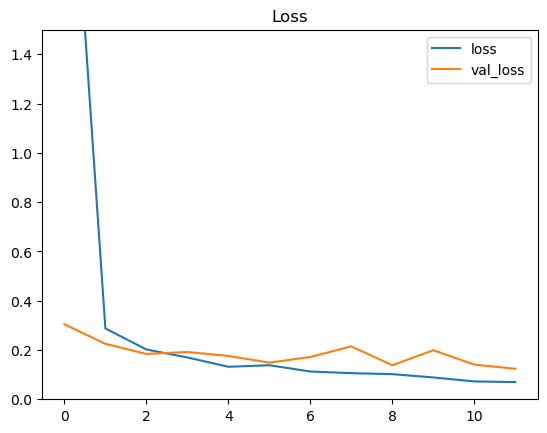

In [57]:
plt.plot(hist.history['loss'], label='loss')
plt.plot(hist.history['val_loss'], label='val_loss')
plt.ylim(0,1.5)
plt.title('Loss')
plt.legend()
plt.show()

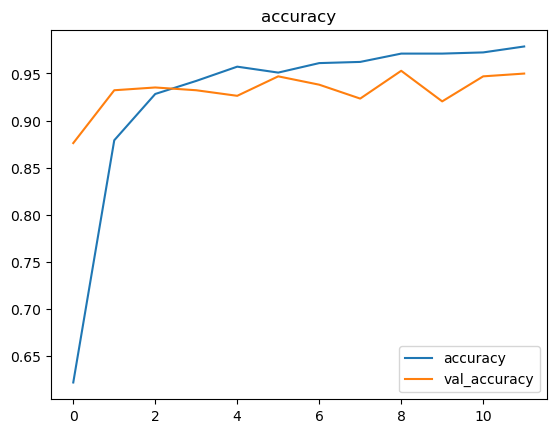

In [60]:
plt.plot(hist.history['accuracy'], label='accuracy')
plt.plot(hist.history['val_accuracy'], label='val_accuracy')
plt.title('accuracy')
plt.legend()
plt.show()

In [61]:
loss, acc = model.evaluate(test_gen, verbose=0)

print(loss)
print(acc)

0.22353839874267578
0.9205297827720642


In [62]:
model.load_weights('checkpoint_weight.ckpt')
loss, acc = model.evaluate(test_gen, verbose=0)

print(loss)
print(acc)

0.1787976771593094
0.940397322177887


In [63]:
model.save('vgg_check_model.h5')

In [13]:
model = load_model('vgg_check_model.h5') 

file = 'pred_olaf.png'

categories = ['not', 'olaf']
testImage = load_img(file, target_size=(224, 224))
imageArr = np.array(testImage)
imageArr = imageArr/255
imageArr = imageArr.reshape(-1, 224, 224, 3)
imageArr.shape


(1, 224, 224, 3)

In [14]:
preds = model.predict(imageArr)
label = np.argmax(preds)
categories[label]

1/1 [==============================] - 0s 302ms/step


'olaf'

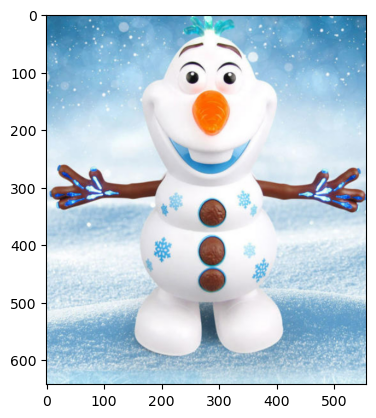

In [18]:
from PIL import Image

sample = Image.open(file)
plt.imshow(sample)